# Clone repository and install requirements

In [1]:
import sys
sys.path.append('C:/Users/asus/text2face/FGTD/scripts')

## Importing dependencies


In [2]:
import os
import random
import functools

import pandas as pd
import numpy as np
from numpy import sqrt, prod
import matplotlib.pyplot as plt
from collections import OrderedDict
from dataclasses import asdict, dataclass

from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import interpolate
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

In [3]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [4]:
# File Constants
ZIP_PATH = "."
OUTPUT_DIR = "C:/Users/asus/text2face/FGTD/dataset/img_align_celeba/"

## Initialize constants

In [5]:
@dataclass
class Config:
    epochs: int = 600
    batch_size: int = 8
    subset_size: int = 20_000
    dataset_len = 202599

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    conditional: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 768

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    uncond_loss: int = 1.0
    colour_loss: int = 0.0
    kl_loss: int = 2.0

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
cfg = Config()
cfg_dict = asdict(cfg)

In [7]:
sentence_encoder = SentenceEncoder(cfg.device)

## Helper functions

In [8]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

# Create DataLoader

In [9]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/asus/text2face/FGTD/dataset/celebA_Bangla.csv',  
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/asus/text2face/FGTD/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'সামনের চুল কম', 'টাই_পরা', 'টুপি_পরা', 'বাদামী_চুল', 'মুখ_কিছুটা_খোলা', 'ঘন_ভ্রু', 'ধূসর_চুল', 'Unnamed: 0', 'মোটা', 'দ্বীত্ব_থুতনি', 'চশমা', 'ফ্যাকাশে', 'লিপস্টিক_পরা', 'গোটি', 'উঁচু_গালের_হাড়', 'চোখের_নিচে_কালি', 'বড়_ঠোঁট', 'কানের_দুল_পরা', 'ভারী_মেকাপ', 'অল্পবয়স্ক', 'সোনালী_চুল', 'জুলফি', 'চোখা_নাক', 'গোলাপী_গাল', 'হালকা_দাড়ি', 'সরু_চোখ', 'কুচকানো_ভুরু', 'বড়_নাক', 'টাক', 'হাসি', 'কালো_চুল', 'কপালে_ছড়ানো_চুল', 'দাড়ি_নেই', 'ডিম্বাকৃতির_চেহারা', 'পুরুষ', 'সোজা_চুল', 'নেকলেস_পরা', 'মোছ', 'আকর্ষণীয়', 'ঢেউ_খেলানো_চুল'}
Number of classes:  40
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing DataLoader output

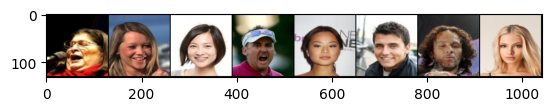

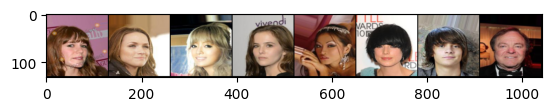

['ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের চোখে চশমা ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের দাড়ি নেই। ', 'মেয়েটির চোখের নিচে কালি ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির সরু চোখ ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির সোজা চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির বড় ঠোঁট ছিল। মেয়েটির কালো চুল ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির সরু চোখ ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির সোজা চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের দাড়ি নেই। ভদ্রলোকটির টুপি পরা ছিল। ', 'মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির কানে দুল পরা ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির দাড়ি নেই। ছেলেটির মুখে ছিল হাসি। ছেলেটির সোজা চুল ছিল। ', 'ভদ্রলোকটির চোখের নিচে কালি ছিল। ভদ্রলোকের সরু চোখ ছিল। ভদ্রলোকটির সামনের

In [10]:
real_images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(real_images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Create Network

In [11]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [12]:
class affine(nn.Module):
  def __init__(self, num_features):
    super(affine, self).__init__()
    self.fc_gamma = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    
    self.fc_beta = nn.Sequential(OrderedDict([
            ('linear1',nn.Linear(256, 256)),
            ('relu1',nn.ReLU(inplace=True)),
            ('linear2',nn.Linear(256, num_features)),
            ]))
    self._initialize()

  def _initialize(self):
    nn.init.zeros_(self.fc_gamma.linear2.weight.data)
    nn.init.ones_(self.fc_gamma.linear2.bias.data)
    nn.init.zeros_(self.fc_beta.linear2.weight.data)
    nn.init.zeros_(self.fc_beta.linear2.bias.data)

  def forward(self, x, y=None):
    weight = self.fc_gamma(y)
    bias = self.fc_beta(y)        

    if weight.dim() == 1:
        weight = weight.unsqueeze(0)
    if bias.dim() == 1:
        bias = bias.unsqueeze(0)

    size = x.size()
    weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
    bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
    return weight * x + bias

In [13]:
class G_Block(nn.Module):
    def __init__(self, in_ch, out_ch):
      super(G_Block, self).__init__()

      self.learnable_sc = in_ch != out_ch 
      self.c1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
      self.c2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
      self.affine0 = affine(in_ch)
      self.affine1 = affine(in_ch)
      self.affine2 = affine(out_ch)
      self.affine3 = affine(out_ch)
      self.gamma = nn.Parameter(torch.zeros(1))
      if self.learnable_sc:
          self.c_sc = nn.Conv2d(in_ch,out_ch, 1, stride=1, padding=0)

    def forward(self, x, y=None):
      return self.shortcut(x) + self.gamma * self.residual(x, y)

    def shortcut(self, x):
      if self.learnable_sc:
          x = self.c_sc(x)
      return x

    def residual(self, x, y=None):
      h = self.affine0(x, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine1(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.c1(h)

      h = self.affine2(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      h = self.affine3(h, y)
      h = nn.LeakyReLU(0.2,inplace=True)(h)
      return self.c2(h)

In [14]:
class NetG(nn.Module):
  def __init__(self, ngf = 64, nz = 100):
    super(NetG, self).__init__()
    self.ngf = ngf
    self.nz = nz

    self.fc = nn.Linear(self.nz, self.ngf * 8 * 4 * 4)
    self.reduce_dim = nn.Linear(768, 256)
    self.block0 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block1 = G_Block(ngf * 8, ngf * 8)#4x4
    self.block2 = G_Block(ngf * 8, ngf * 8)#8x8
    self.block3 = G_Block(ngf * 8, ngf * 8)#16x16
    self.block4 = G_Block(ngf * 8, ngf * 4)#32x32
    self.block5 = G_Block(ngf * 4, ngf)#64x64
    # self.block6 = G_Block(ngf * 2, ngf * 1)#128x128

    self.conv_img = nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ngf, 3, 3, 1, 1),
            nn.Tanh(),
        )
    
  def forward(self, x, c):
    out = self.fc(x)
    out = out.view(x.size(0), 8*self.ngf, 4, 4)
    c = self.reduce_dim(c)
    out = self.block0(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block1(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block2(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block3(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block4(out,c)

    out = F.interpolate(out, scale_factor=2)
    out = self.block5(out,c)

    # out = F.interpolate(out, scale_factor=2)
    # out = self.block6(out,c)

    out = self.conv_img(out)

    return out

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class D_GET_LOGITS(nn.Module):
    def __init__(self, ndf):
      super(D_GET_LOGITS, self).__init__()
      self.df_dim = ndf

      self.reduced_dim = nn.Linear(768, 256)

      self.joint_conv = nn.Sequential(
          nn.Conv2d(ndf * 16+256, ndf * 2, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2,inplace=True),
          nn.Conv2d(ndf * 2, 1, 2, 1, 0, bias=False),
      )

    def forward(self, out, y):
      y = self.reduced_dim(y)
      y = y.view(-1, 256, 1, 1)
      y = y.repeat(1, 1, 2, 2)
      h_c_code = torch.cat((out, y), 1)
      out = self.joint_conv(h_c_code)
      # print(out.shape)
      return out

In [17]:
class resD(nn.Module):
    def __init__(self, fin, fout, downsample=True):
      super().__init__()
      self.downsample = downsample
      self.learned_shortcut = (fin != fout)
      self.conv_r = nn.Sequential(
          nn.Conv2d(fin, fout, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
          
          nn.Conv2d(fout, fout, 3, 1, 1, bias=False),
          nn.LeakyReLU(0.2, inplace=True),
      )

      self.conv_s = nn.Conv2d(fin,fout, 1, stride=1, padding=0)
      self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x, c=None):
      return self.shortcut(x)+self.gamma*self.residual(x)

    def shortcut(self, x):
      if self.learned_shortcut:
          x = self.conv_s(x)
      if self.downsample:
          return F.avg_pool2d(x, 2)
      return x

    def residual(self, x):
      return self.conv_r(x)

In [18]:
class NetD(nn.Module):
    def __init__(self, ndf):
      super(NetD, self).__init__()

      self.conv_img = nn.Conv2d(3, ndf, 3, 1, 1)#128
      self.block0 = resD(ndf * 1, ndf * 2)#64
      self.block1 = resD(ndf * 2, ndf * 4)#32
      self.block2 = resD(ndf * 4, ndf * 8)#16
      self.block3 = resD(ndf * 8, ndf * 16)#8
      self.block4 = resD(ndf * 16, ndf * 16)#4
      self.block5 = resD(ndf * 16, ndf * 16)#4

      self.COND_DNET = D_GET_LOGITS(ndf)

    def forward(self,x):
      out = self.conv_img(x)
      out = self.block0(out)
      out = self.block1(out)
      out = self.block2(out)
      out = self.block3(out)
      out = self.block4(out)
      out = self.block5(out)
      return out

## Training


In [19]:
netG = NetG(64, 100).to(device)
netD = NetD(64).to(device)

netG.cuda().train()
netD.cuda().train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

In [21]:
summary(netG,input_size=[(8,100),(8,768)],col_names=("output_size", "num_params"))

Layer (type:depth-idx)                   Output Shape              Param #
NetG                                     [8, 3, 128, 128]          --
├─Linear: 1-1                            [8, 8192]                 827,392
├─Linear: 1-2                            [8, 256]                  196,864
├─G_Block: 1-3                           [8, 512, 4, 4]            1
│    └─affine: 2-1                       [8, 512, 4, 4]            --
│    │    └─Sequential: 3-1              [8, 512]                  197,376
│    │    └─Sequential: 3-2              [8, 512]                  197,376
│    └─affine: 2-2                       [8, 512, 4, 4]            --
│    │    └─Sequential: 3-3              [8, 512]                  197,376
│    │    └─Sequential: 3-4              [8, 512]                  197,376
│    └─Conv2d: 2-3                       [8, 512, 4, 4]            2,359,808
│    └─affine: 2-4                       [8, 512, 4, 4]            --
│    │    └─Sequential: 3-5              [8, 512]

In [24]:
summary(netD,input_size=[(8,3,128,128)],col_names=("output_size", "num_params"))

Layer (type:depth-idx)                   Output Shape              Param #
NetD                                     [8, 1024, 2, 2]           1,671,936
├─Conv2d: 1-1                            [8, 64, 128, 128]         1,792
├─resD: 1-2                              [8, 128, 64, 64]          1
│    └─Conv2d: 2-1                       [8, 128, 128, 128]        8,320
│    └─Sequential: 2-2                   [8, 128, 64, 64]          --
│    │    └─Conv2d: 3-1                  [8, 128, 64, 64]          131,072
│    │    └─LeakyReLU: 3-2               [8, 128, 64, 64]          --
│    │    └─Conv2d: 3-3                  [8, 128, 64, 64]          147,456
│    │    └─LeakyReLU: 3-4               [8, 128, 64, 64]          --
├─resD: 1-3                              [8, 256, 32, 32]          1
│    └─Conv2d: 2-3                       [8, 256, 64, 64]          33,024
│    └─Sequential: 2-4                   [8, 256, 32, 32]          --
│    │    └─Conv2d: 3-5                  [8, 256, 32, 32]   

In [21]:
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0004, betas=(0.0, 0.9))  

In [22]:
plt_images, plt_labels, fake_img = weighted_dataiter._next_data()
fixed_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_embeddings.shape

torch.Size([8, 768])

In [23]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [24]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    netG.eval()
    test_images = netG(fixed_noise, fixed_embeddings)
    netG.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [25]:
epoch = 0

In [26]:
g_Losses = []
d_Losses = []

In [27]:
checkpoint_path = "C:/Users/asus/text2face/FGTD/Face-GANs/DFGAN/checkpoints/cp.pt"

In [ ]:
pbar = tqdm()

while epoch<cfg.epochs:
  print(f'Epoch : {epoch + 1} / {cfg.epochs}')
  pbar.reset(total = len(weighted_dataloader))

  discriminator_loss = []
  generator_loss = []

  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    current_batch_size = real_images.size()[0]

    #convert to CUDA
    real_images = real_images.cuda()
    text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
    wrong_images = wrong_images.cuda()

    real_validity = torch.ones(current_batch_size, 1).cuda()
    fake_validity = torch.zeros(current_batch_size, 1).cuda()

    temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
    smoothed_real_labels = torch.add(real_validity, temp_tensor)

    real_features = netD(real_images)
    output = netD.COND_DNET(real_features,text_embeddings)
    errD_real = torch.nn.ReLU()(1.0 - output).mean()

    output = netD.COND_DNET(real_features[:(current_batch_size - 1)], text_embeddings[1:current_batch_size])
    errD_mismatch = torch.nn.ReLU()(1.0 + output).mean()

    # synthesize fake images
    noise = torch.randn(current_batch_size, 100)
    noise=noise.to(device)
    fake = netG(noise,text_embeddings)

    # G does not need update with D
    fake_features = netD(fake.detach()) 

    errD_fake = netD.COND_DNET(fake_features,text_embeddings)
    errD_fake = torch.nn.ReLU()(1.0 + errD_fake).mean()  

    errD = errD_real + (errD_fake + errD_mismatch)/2.0
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    errD.backward()
    optimizerD.step() 

    #MA-GP
    interpolated = (real_images.data).requires_grad_()
    sent_inter = (text_embeddings.data).requires_grad_()
    features = netD(interpolated)
    out = netD.COND_DNET(features,sent_inter)
    grads = torch.autograd.grad(outputs=out,
                            inputs=(interpolated,sent_inter),
                            grad_outputs=torch.ones(out.size()).cuda(),
                            retain_graph=True,
                            create_graph=True,
                            only_inputs=True)
    grad0 = grads[0].view(grads[0].size(0), -1)
    grad1 = grads[1].view(grads[1].size(0), -1)
    grad = torch.cat((grad0,grad1),dim=1)                        
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm) ** 6)
    d_loss = 2.0 * d_loss_gp
    optimizerD.zero_grad()
    optimizerG.zero_grad()
    d_loss.backward()
    optimizerD.step()

    # update G
    features = netD(fake)
    output = netD.COND_DNET(features,text_embeddings)
    errG = - output.mean()
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    errG.backward()
    optimizerG.step()
    # print(f'Loss_D : {errD.item()}')

    pbar.update()

  print('\n')
  print(f'Epoch : {epoch + 1} | Loss_D : {errD.item()} | Loss_G : {errG.item()}')

  if (epoch + 1) % 1 == 0:
    plot_output(epoch + 1)

  g_Losses.append(errG.item())
  d_Losses.append(errD.item())

  checkpoint = {
    'epoch': epoch,
    'generator_state_dict': netG.state_dict(),
    'generator_optimizer': optimizerG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'discriminator_optimizer': optimizerD.state_dict(),
    'g_Losses' : g_Losses,
    'd_Losses' : d_Losses
    }

  torch.save(checkpoint,checkpoint_path)
  
  epoch+=1

pbar.refresh()
  

# Load Checkpoint

In [29]:
checkpoint = torch.load(checkpoint_path)
netG.load_state_dict(checkpoint['generator_state_dict'])
optimizerG.load_state_dict(checkpoint['generator_optimizer'])
netD.load_state_dict(checkpoint['discriminator_state_dict'])
optimizerD.load_state_dict(checkpoint['discriminator_optimizer'])
epoch = checkpoint['epoch']
g_Losses = checkpoint['g_Losses']
d_Losses = checkpoint['d_Losses']
netG.train()
netD.train()

NetD(
  (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block0): resD(
    (conv_r): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block1): resD(
    (conv_r): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv_s): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): resD(
    (conv_r): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), s

# Plotting losses of D and G

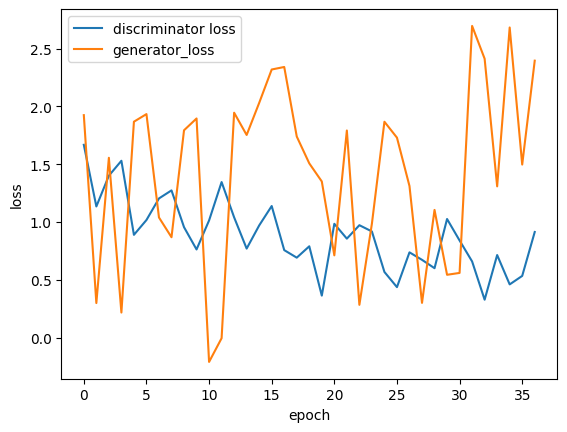

In [30]:
plt.plot(checkpoint['d_Losses'],label='discriminator loss')
plt.plot(checkpoint['g_Losses'],label='generator_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper left")
plt.show()

## Testing

In [31]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['''
The woman has high cheekbones.
She has straight hair which is
brown in colour. She has arched
eyebrows and a slightly open
mouth. The smiling, young attractive woman has heavy makeup. She
is wearing lipstick.
'''])

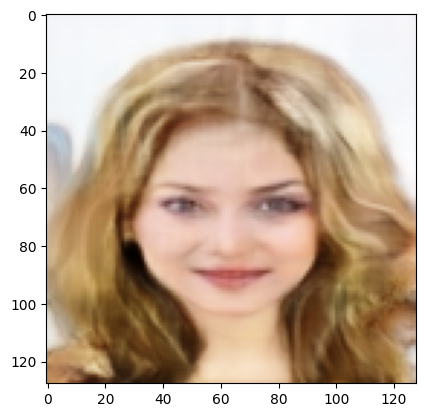

In [32]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [33]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

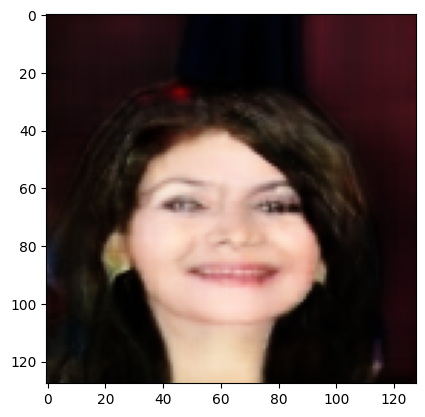

In [34]:
netG.eval()
test_image = netG(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

# Save and Load Model

In [35]:
PATH = 'C:/Users/DELL/FGTD-master/Face-GANs/SAGAN/generator.pt'

In [36]:
torch.save(netG.state_dict(), PATH)

In [38]:
model = NetG(64, 100).to(device)
model.load_state_dict(torch.load(PATH))
model.cuda()
model.eval()

NetG(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (reduce_dim): Linear(in_features=768, out_features=256, bias=True)
  (block0): G_Block(
    (c1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (affine0): affine(
      (fc_gamma): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
      )
      (fc_beta): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
      )
    )
    (affine1): affine(
      (fc_gamma): Sequential(
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, 

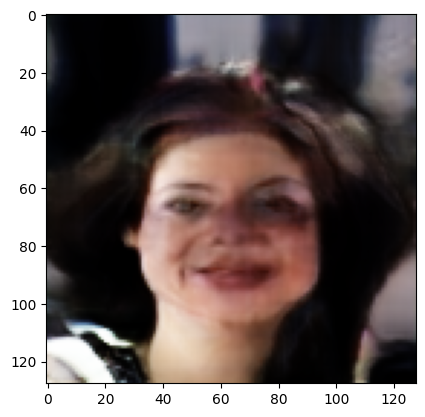

In [45]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['Her hair is black. She has a slightly open mouth. The female is smiling and has heavy makeup.'])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))